# Descrição

Nessa tarefa você vai estender sua implementação da tarefa passada para considerar múltiplas variáveis. Você pode estender a versão vetorizada implementada neste notebook para regressão simples. 

- Rode o algoritmo nesses dados, onde as linhas representam as notas de alunos de computação de alunos da UFCG em algumas disciplinas do primeiro período. A última coluna é a variável alvo representando o CRA final depois de concluir o curso. As outras colunas são algumas disciplinas do primeiro período. O pressuposto aqui é que as notas em disciplinas no primeiro período ajudam a explicar o CRA final dos alunos de computação.

- Compare o valor dos coeficientes estimados pelo seu algoritmo com o valor dos coeficientes da regressão linear do scikit learn para testar se o seu algoritmo está funcionando corretamente.

A entrega deve ser o link no seu github para o notebook Jupyter com código python e texto explicativo quando necessário. De preferência, crie um repositório na sua conta do github e envie o link do html do notebook.

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import sklearn as sc

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(style="ticks")

# Load Data

In [2]:
grades_df = pd.read_csv('../data/grades.csv')
grades_df.rename(index=str, columns={'Cálculo1': 'Calc1', 'Cálculo2': 'Calc2'}, inplace=True)
grades_df.head()

,Calc1,LPT,P1,IC,Calc2,cra
0,8.7,10.0,9.0,9.1,8.4,8.477647
1,7.0,7.0,7.7,7.0,6.2,6.851724
2,8.6,9.8,7.9,9.6,8.7,9.090588
3,7.8,8.3,6.8,8.2,8.0,7.283516
4,5.2,9.3,5.0,8.5,5.0,7.205747


### Check Dataset Size

In [3]:
grades_df.shape

(88, 6)

In [4]:
grades_df_aux = pd.DataFrame(grades_df)
grades_df_aux['Status'] = grades_df_aux.cra.apply(lambda x:  "Success" if x >= 7 else "Fail")
grades_df_aux.head()

,Calc1,LPT,P1,IC,Calc2,cra,Status
0,8.7,10.0,9.0,9.1,8.4,8.477647,Success
1,7.0,7.0,7.7,7.0,6.2,6.851724,Fail
2,8.6,9.8,7.9,9.6,8.7,9.090588,Success
3,7.8,8.3,6.8,8.2,8.0,7.283516,Success
4,5.2,9.3,5.0,8.5,5.0,7.205747,Success


### Plot Scatterplots

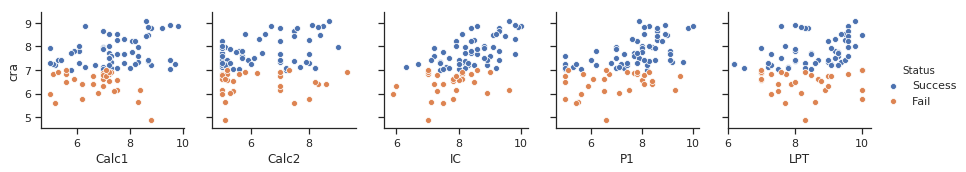

In [5]:
sns.pairplot(grades_df_aux, hue="Status", y_vars=['cra'], x_vars=['Calc1', 'Calc2','IC','P1','LPT'])

## Define Functions

### Compute Mean Squared Error - Vectorized Version

$MSE(\hat{w})=\frac{1}{N}(y-\hat{\mathbf{w}}^T\mathbf{x})^T(y-\hat{\mathbf{w}}^T\mathbf{x})$

In [48]:
def compute_mse_vectorized(w, X, Y):
    print("w.shape: " + str(w.shape))
    print("X.shape: " + str(X.shape))
    print("Y.shape: " + str(Y.shape))
    res = Y - np.dot(X,w)
    totalError = np.dot(res.T,res)
    return totalError / float(len(Y))

### Função para fazer uma atualização dos parâmetros no Gradiente Descendente:

$w_0 = w_0 + 2\alpha\sum_{i=1}^N (y_i - (w_0+w_1x_i))$

$w_1 = w_1 + 2\alpha\sum_{i=1}^N x_i(y_i - (w_0+w_1x_i))$

In [7]:
def step_gradient_vectorized(w_current, X, Y, learningRate):
    res = Y - np.dot(X,w_current)
    b_gradient = np.sum(res)
    X = X[:,1][:,np.newaxis]
    m_gradient = np.sum(np.multiply(res,X))
    new_w = np.array([(w_current[0] + (2 * learningRate * b_gradient)),
             (w_current[1] + (2 * learningRate * m_gradient))])
    
    new_error = compute_mse_vectorized(new_w, X, Y)
    l2_norm = np.linalg.norm([b_gradient, m_gradient], ord=2)  # compute l2-norm
    
    return [new_w, grads, new_error, l2_norm]

In [8]:
def gradient_descent_runner_vectorized(starting_w, X, Y, learning_rate, epsilon, verbose=False, period=1000):
    history = pd.DataFrame(columns=['w0_grad','w1_grad','w2_grad', 'w3_grad','w4_grad','error','iter'])
    w = starting_w
    grad = np.array([np.inf,np.inf])
    i = 0
    while (np.linalg.norm(grad) >= epsilon):
        step_grad = step_gradient_vectorized(w, X, Y, learning_rate, i, True)
        w, b_gradient, m_gradient = 
        grad = np.array([b_gradient,m_gradient])
        
        if verbose:
            if i % period == 0:
                print("MSE na iteração {0} é de {1}".format(i,compute_mse_vectorized(w, X, Y)))
        
        i+= 1
        
    return w

In [53]:
def run():
    X = grades_df.iloc[:, 0:5]
    Y = grades_df.cra[:,np.newaxis]
    init_w = np.zeros((X.shape[1],1))
    
    learning_rate = 1e-3
    epsilon = 1e-3
    
    initial_error = compute_mse_vectorized(init_w, X,Y)
    print("Starting gradient descent at w0 = {0}, w1 = {1}, w2 = {2}, w3 = {3}, w4 = {4}, error = {5}".format(init_w[0], init_w[1], init_w[2], 
                                                                                                              init_w[3], init_w[4], initial_error))
    print("Running...")
    
    history = gradient_descent_runner_vectorized(init_w, X, Y, learning_rate, epsilon)
    
    #w = history[]
    
    #final_error = compute_mse_vectorized(w, X,Y)
    #num_iterations_need = history['iter'][history.shape[0]-1]
    
    #print("After {0} iterations b = {1}, m = {2}, error = {3}".format(num_iterations_need, final_bias, final_slope, final_error))
    #print("Learning Rate = {}".format(learning_rate))
    
    return history    

run()

w.shape: (5, 1)
X.shape: (88, 5)
Y.shape: (88, 1)
Starting gradient descent at w0 = [0.], w1 = [0.], w2 = [0.], w3 = [0.], w4 = [0.], error = [[54.47995386]]
Running...


TypeError: step_gradient_vectorized() missing 1 required positional argument: 'itera'

In [ ]:


"""def step_gradient(b_current, m_current, points, learningRate, itera, verbose=False, period=1000):
    b_gradient = 0
    m_gradient = 0
    N = float(len(points))
    for i in range(0, len(points)):
        x = points[i, 0]
        y = points[i, 1]
        b_gradient += -(2/N) * (y - ((m_current * x) + b_current))
        m_gradient += -(2/N) * x * (y - ((m_current * x) + b_current))
    new_b = b_current - (learningRate * b_gradient)
    new_m = m_current - (learningRate * m_gradient)
    
    new_error = compute_error_for_line_given_points(new_b, new_m, points)
    l2_norm = np.linalg.norm([b_gradient, m_gradient], ord=2)  # compute l2-norm
    
    if verbose:
        if itera % period == 0:
            print("Step gradient at b = {0}, m = {1}, error = {2}, l2_norm = {3}".format(new_b, new_m, new_error, l2_norm))
       
    return [new_b, new_m, b_gradient, m_gradient, new_error]"""

"""def gradient_descent_runner_vectorized(starting_w, X, Y, learning_rate, num_iterations, epsilon):
    w = starting_w
    history = pd.DataFrame(columns=['bias','slope','bias_grad', 'slope_grad','error','iter'])
    l2_norm = np.linalg.norm([float('inf'),float('inf')])
    iteration = 0
    while(l2_norm >= epsilon):
        step_grad = step_gradient_vectorized(w, np.array(points), learning_rate, iteration, True)
        history = history.append({'bias': step_grad[0], 'slope': step_grad[1], 'bias_grad': step_grad[2],
                        'slope_grad': step_grad[3], 'error': step_grad[4], 'iter': iteration}, ignore_index=True)
        b, m, b_gradient, m_gradient, l2_norm = step_grad[0], step_grad[1], step_grad[2], step_grad[3], step_grad[4]
        iteration += 1
        
    return history"""

"""def run():
    points = np.genfromtxt("../data/income.csv", delimiter=",")
    learning_rate = 3 * 1e-3
    initial_b = 0 # initial y-intercept guess
    initial_m = 0 # initial slope guess
    num_iterations = 20000
    
    initial_error = compute_error_for_line_given_points(initial_b, initial_m, points)
    print("Starting gradient descent at b = {0}, m = {1}, error = {2}".format(initial_b, initial_m, initial_error))
    print("Running...")
    
    history = gradient_descent_runner(points, initial_b, initial_m, learning_rate, num_iterations)
    
    final_bias = history['bias'][history.shape[0]-1]
    final_slope = history['slope'][history.shape[0]-1]
    final_error = compute_error_for_line_given_points(final_bias, final_slope, points)
    num_iterations_need = history['iter'][history.shape[0]-1]
    
    print("After {0} iterations b = {1}, m = {2}, error = {3}".format(num_iterations_need, final_bias, final_slope, final_error))
    print("Learning Rate = {}".format(learning_rate))
    
    return history"""

## Define Plot Functions

In [ ]:
def plot_predicted_model(hist):
    predictions_df = pd.DataFrame(df)
    predictions_df = predictions_df.rename(index=str, columns={0 : 'Year', 1: 'Income'})
    predictions_df.insert(loc=2, column='Predicted_Income', value=0.0)
    
    final_model = [hist['bias'][hist.shape[0]-1], hist['slope'][hist.shape[0]-1]]
    model_slope = final_model[1]
    model_bias = final_model[0]

    for i in range(0, predictions_df.shape[0]):
        year = predictions_df['Year'][i]
        predictions_df['Predicted_Income'][i] = '{:2.6f}'.format(year * model_slope + model_bias)

    plt.plot(predictions_df['Year'], predictions_df['Income'], 'bo', label='Original Data') 
    plt.plot(predictions_df['Year'], predictions_df['Predicted_Income'], 'r', label='Predicted Model') 
    plt.title('Comparison of Original Income and Predicted Income') 
    plt.xlabel('Years of Study')
    plt.ylabel('Income in US$ 1000.00')
    plt.legend()

    plt.figure()
    plt.show()
    

In [ ]:
def plot_model_error_on_training(hist):
    plt.plot(hist['iter'], hist['error'] , 'r', label='Model Error') 
    plt.title('Model Error (RSS) By Iteration') 
    plt.legend()

    plt.figure()

    plt.show()

In [ ]:
def plot_gradient_on_training(hist):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    ax.scatter(hist['iter'], 
               hist['bias_grad'], 
               hist['slope_grad'])
    ax.set_ylabel('Bias Gradient')
    ax.set_zlabel('Slope Gradient')
    ax.set_xlabel('Iter')
    
    plt.show()

In [ ]:
hist_1 = run()

#plot_model_error_on_training(hist_item_5)
#plot_predicted_model(hist_item_5)
#plot_gradient_on_training(hist_item_5)